In [ ]:
import glob
import pandas as pd


data_files = glob.glob("chess_ratings/*.csv")
all_dfs = [pd.read_csv(file, sep='|') for file in data_files]

# Chess ratings
This document analyses the dataset of Chess ratings from the FIDE.

In [4]:
example_df = all_dfs[5].iloc[:10]
example_df

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,Rat,Gms,K,B-day,Flag,Year,Mon
0,35077023,A Chakravarthy,IND,M,NaN,NaN,NaN,NaN,1151,0,40,1986,i,2018,5
1,10207538,"A E M, Doshtagir",BAN,M,NaN,NaN,NaN,NaN,1840,0,40,1974,i,2018,5
2,5716365,"A Hamid, Harman",MAS,M,NaN,NaN,NI,NaN,1385,6,40,0,NaN,2018,5
3,10206612,"A K M, Sourab",BAN,M,NaN,NaN,NaN,NaN,1708,0,40,0,NaN,2018,5
4,5045886,"A K, Kalshyan",IND,M,NaN,NaN,NaN,NaN,1841,0,20,1964,NaN,2018,5
5,8605360,"A La, Teng Hua",CHN,F,NaN,NaN,NaN,NaN,1915,0,40,1993,wi,2018,5
6,5716373,"A Rajah, Abdul Shukor",MAS,M,NaN,NaN,NaN,NaN,1809,0,40,0,i,2018,5
7,10231447,"A S M Khalid, Hasan",BAN,M,NaN,NaN,NaN,NaN,1585,0,40,1988,NaN,2018,5
8,5080444,"A, Sohita",IND,F,NaN,NaN,NaN,NaN,1447,0,40,1995,wi,2018,5
9,4804929,"A-ALI,Sali Abbas Abdulzahra",IRQ,F,WFM,WFM,NaN,NaN,1762,0,40,2001,w,2018,5


# Description
The dataset contains data of chess players registered in FIDE (The International Chess Federation). One example represents data of games and ratings of a player. The data is aggregated by months, and it ranges from December 2017 to December 2019. Both male and female players are represented, there are separate titles for women, but some female players compete in the original categories (mixed gender) as well.

There are over 350k unique players.

In [5]:
data = pd.concat(all_dfs)
data["Year / month"] = [f"{y} / {m if (len(str(m)) == 2) else ('0' + str(m))}" for y, m in zip(data["Year"], data["Mon"])]

In [6]:
"Players: " + str(len(data['ID Number'].unique()))

'Players: 354525'

## Column meanings

Column | Description
--- | ---
'ID Number', 'Name' | ID, name of the player
'Fed', 'Sex', 'B-day' | Country, gender and birth year
'Tit', 'WTit' | Title and female title
'OTit' | Other titles, e.g. Arbiter, Trainer...
'FOA' | FIDE online arena rating
'Rat' | Rating of the player
'Gms' | Number of games played in the month
'K' | development coefficient
'Flag' | (in)activity flag
'Year', 'Mon' | Month and year of the entry


---------------
source: https://ratings.fide.com/download_lists.phtml

K factor: https://en.wikipedia.org/wiki/Elo_rating_system#:~:text=United%20States%20Chess%20Federation%20ratings,-The%20United%20States&text=The%20K-factor,%20in%20the,in%20a%20tournament%20(m).

In [7]:
max_k = data[["ID Number", "K"]].groupby("ID Number").max()

# Player data and demographics

## Countries
There are players from 192 different countries registered. Czechia is the 10th in player count, and Russia has the most chess players overall. 

In [8]:
country_ppl = data[['ID Number', 'Fed']].drop_duplicates()

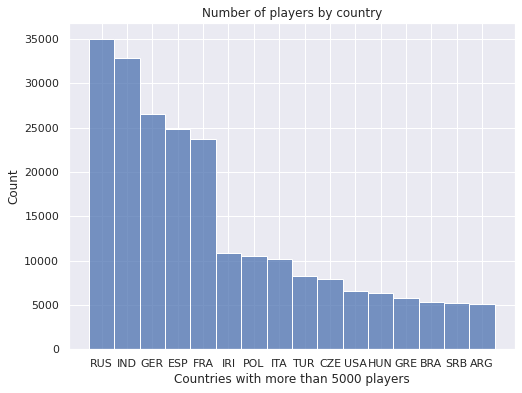

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline


n_in_country = country_ppl.groupby(['Fed']).count()
n_in_country = n_in_country.sort_values(by='ID Number', ascending=False)

plt.figure(figsize=(8, 6))
sns.histplot(data=n_in_country[n_in_country["ID Number"] > 5000].reset_index(), x='Fed', weights='ID Number', discrete=True)
plt.title("Number of players by country")
plt.xlabel("Countries with more than 5000 players")
plt.show()

In [13]:
print("Countries:", len(data['Fed'].unique()))
print("Countries with more than 5000 players:", len(n_in_country[n_in_country["ID Number"] > 5000]))

Countries: 192
Countries with more than 5000 players: 16


## Player age
The most active players are children and young adults. With age, the interest in chess declines, with a slight increase close to retirement. Elderly people have a decline in active counts probably due to their worse health and lower population count.

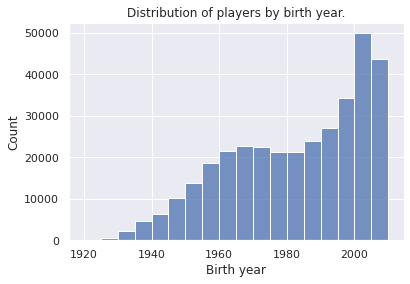

In [18]:
age_ppl = data[['ID Number', 'B-day']].drop_duplicates().reset_index()

plt.title("Distribution of players by birth year.")
sns.histplot(data=age_ppl[age_ppl['B-day'] > 1900], x='B-day', binrange=[1920, 2010], binwidth=5)
plt.xlabel("Birth year")
plt.show()

## Activity

Activity flag is different for women and men competitions. The value nan means "active man", which is bad practice, we will create a new boolean column indicating activity regardless of gender.

In [19]:
example_df.Flag.unique()

array(['i', nan, 'wi', 'w'], dtype=object)

In [20]:
(example_df[example_df.Flag == 'wi'].Sex.unique())
(example_df[example_df.Flag == 'w'].Sex.unique())
pass

In [21]:
data["active"] = True
data.loc[~data["Flag"].isna() & data["Flag"].str.contains("i"), "active"] = False

There is much less women chess players than men chess players.

The distribution of active month counts is mostly uniform, with larger number of players active for 1 year, and a lot of players were active the whole time.

In [22]:
n_years = data[data["active"]][['ID Number', 'Sex', 'Year']].groupby(['ID Number', 'Sex']).count()

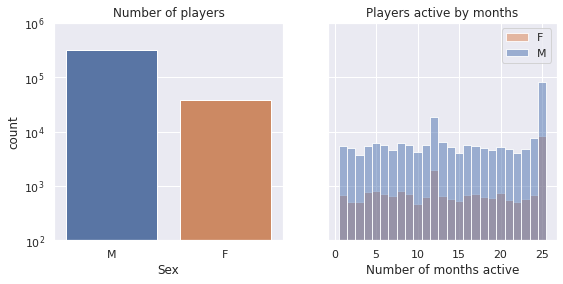

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(9,4), sharey=True)

sns.countplot(data=data[["ID Number", "Sex"]].drop_duplicates(["ID Number", "Sex"]), x="Sex", ax=axs[0])
plt.ylim(10**2, 10**6)
axs[0].set_xlabel("Sex")
axs[0].set_title("Number of players")
plt.yscale('log')

sns.histplot(data=n_years, x='Year', hue='Sex', discrete=True, log_scale=(False, True), ax=axs[1])
axs[1].legend(["F", "M"], loc='upper right')
plt.ylim(10**2, 10**6)
axs[1].set_xlabel("Number of months active")
axs[1].set_title("Players active by months")
plt.show()

The overall number of registered players increased during the time interval, however number of active players increased at a slower pace.

In [24]:
inactive_counts = data[["Year", "Mon", "active"]].groupby(["Year", "Mon"]).sum()
#inactive_counts = inactive_counts.sum() / inactive_counts.count()
inactive_counts = inactive_counts.reset_index()
inactive_counts["Year / month"] = [f"{y} / {m if (len(str(m)) == 2) else ('0' + str(m))}" for y, m in zip(inactive_counts["Year"], inactive_counts["Mon"])]

In [25]:
all_counts = data[["Year", "Mon", "ID Number"]].groupby(["Year", "Mon"]).count()
all_counts = all_counts.reset_index()
all_counts["Year / month"] = [f"{y} / {m if (len(str(m)) == 2) else ('0' + str(m))}" for y, m in zip(all_counts["Year"], all_counts["Mon"])]

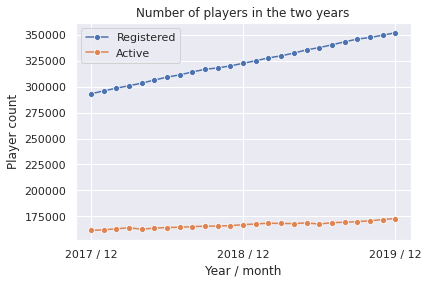

In [26]:
sns.lineplot(data=all_counts, x="Year / month", y="ID Number", marker='o', label='Registered')
sns.lineplot(data=inactive_counts, x="Year / month", y="active", marker='o', label='Active')

plt.xticks(["2017 / 12", "2018 / 12", "2019 / 12"])
plt.title("Number of players in the two years")
plt.ylabel("Player count")
plt.show()

### Number of games played

In a single month, players usually engaged in less than 20 games, mostly playing less than 10 games.

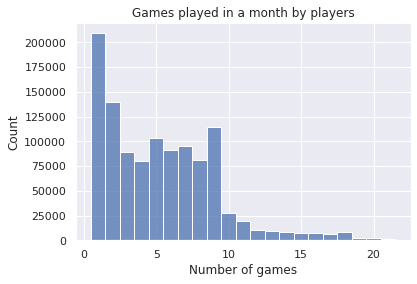

In [27]:
plt.title("Games played in a month by players")
sns.histplot(data['Gms'][(data['Gms'] < 22) & (data['Gms'] > 0)], discrete=True)
plt.xlabel("Number of games")
plt.ylabel("Count")
plt.show()

# Titles and ratings

FIDE arena titles are divers:

In [28]:
data.FOA.unique()

array([nan, 'ACM', 'AIM', 'AFM', 'AGM', 'FI,FA,IA,FT,IO,SIAGM', 'SI,SI',
       'IA', 'FST', 'IO', 'FI    AIM', 'IO,FT', 'FT', 'SI', 'IA    AGM',
       ',IO', 'IA,SI', 'FI', 'DI'], dtype=object)

For simplicity, we will focus on the main rating classes. The titles of FIDE are the following:

- CM - Candidate Master
- FM - FIDE Master
- IM - International Master
- GM - Grand Master

Women titles have a prefix of "W". The titles are achieved by 11 % of women and only 5 % of men.

In [29]:
data["WTit_filled"] = data["WTit"].fillna('None')
data["Tit_filled"] = data["Tit"].fillna('None')

titles = data[["ID Number", "Sex", "WTit_filled", "Tit_filled"]].drop_duplicates(["ID Number", "WTit_filled", "Tit_filled"])

ftitles = titles[(titles["Sex"] == "F")]
mtitles = titles[(titles["Sex"] == "M")]

Proportion of women with titles: 0.11
Proportion of men with titles: 0.05


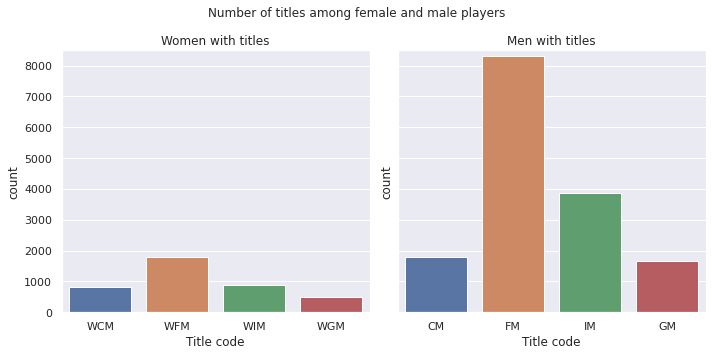

In [30]:
print("Proportion of women with titles:", round(len(ftitles[ftitles["Tit_filled"] != "None"]) / len(ftitles), 2))
print("Proportion of men with titles:", round(len(mtitles[mtitles["Tit_filled"] != "None"]) / len(mtitles), 2))

fig, axs = plt.subplots(ncols=2, figsize=(10,5), sharey=True)
sns.countplot(data=titles[titles["Sex"] == "F"], x="WTit_filled",
              order=["WCM", "WFM", "WIM", "WGM"], ax=axs[0])
plt.ylim((0, 8000))

axs[0].set_title("Women with titles")
axs[1].set_title("Men with titles")

axs[0].set_xlabel("Title code")

sns.countplot(data=titles[titles["Sex"] == "M"], x="Tit_filled",
              order=["CM", "FM", "IM", "GM"], ax=axs[1])
axs[1].set_xlabel("Title code")

plt.suptitle("Number of titles among female and male players")
plt.ylim(0, 8500)
plt.tight_layout()
plt.show()

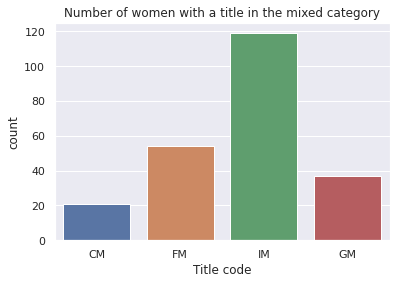

In [31]:
sns.countplot(data=titles[titles["Sex"] == "F"], x="Tit_filled", order=["CM", "FM", "IM", "GM"])
plt.title("Number of women with a title in the mixed category")
plt.xlabel("Title code")
plt.show()

The rating distributions match the prestige of a title, with better titles awarded to higher ranking players. In the male division, the rating distributions are more narrow than in the female section. The FIDE master title is occassionally achieved by some players with a low rating, while the better titles are awarded mostly to players with a very high rating

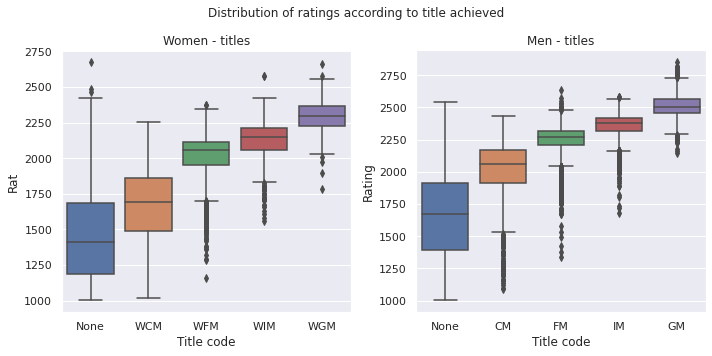

In [32]:
data["WTit_filled"] = data["WTit"].fillna('None')
data["Tit_filled"] = data["Tit"].fillna('None')


def group_rating(d, title):
    name = f"{title}_filled"
    d[name] = d[title].fillna("None")
    
    return d[["ID Number", "Rat", name]].groupby(["ID Number", name]).mean().reset_index()

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(data=group_rating(data[data["Sex"] == "F"].copy(), "WTit"), x='WTit_filled', y="Rat",
            order=["None", "WCM", "WFM", "WIM", "WGM"], ax=axs[0])
plt.ylabel("Rating")

sns.boxplot(data=group_rating(data[data["Sex"] == "M"].copy(), "Tit"), x='Tit_filled', y="Rat",
            order=["None", "CM", "FM", "IM", "GM"], ax=axs[1])

axs[0].set_title("Women - titles")
axs[1].set_title("Men - titles")

plt.suptitle("Distribution of ratings according to title achieved")
plt.ylabel("Rating")
axs[0].set_xlabel("Title code")
axs[1].set_xlabel("Title code")
plt.tight_layout()
plt.show()

Finally, we analyzed the score of players that were active in the whole period of 2 years. Specifically, we analyzed how much the score from 12/2019 improved compared to 12/2017. We plot the difference between the two scores.

In the male section, half of the players got better and the other half got worse. For most players, the score difference was not that large, however there were some outliers with a very large improvement. In the female category, slightly more than a half improved, and the score differences were for most players quite noticeable.

In [33]:
active_ppl = data[data["active"]][["ID Number", "Mon"]].groupby("ID Number").count()

all_timers = active_ppl[active_ppl["Mon"] == 25]
all_timers = data[data["ID Number"].isin(all_timers.index)].reset_index()
print("Number of players active the whole time: ", len(all_timers["ID Number"].unique()))

Number of players active the whole time:  89077


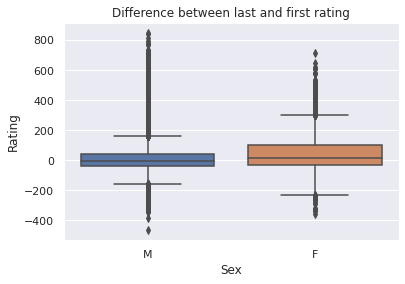

In [34]:
first_month = all_timers[all_timers["Year / month"] == "2017 / 12"].set_index("ID Number")
last_month = all_timers[all_timers["Year / month"] == "2019 / 12"].set_index("ID Number")

rating_diff = last_month["Rat"] - first_month["Rat"]
rating_diff = rating_diff.to_frame()
rating_diff["Sex"] = first_month["Sex"]

plt.title("Difference between last and first rating")
sns.boxplot(data=rating_diff, x="Sex", y="Rat")
plt.ylabel("Rating")
plt.show()

## K factor
The explanation of the K factor is the following:

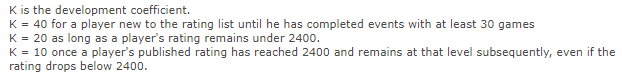

https://ratings.fide.com/calculator_rtd.phtml

Most players have played only few games, or have a rating under 2400.

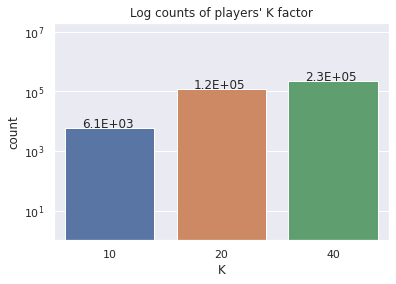

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

ax = sns.countplot(data=max_k, x="K", order=[10, 20, 40])
ax.set_yscale('log')
ax.set_ylim(1, 2*10**7)
ax.set_yticks([10, 10**3, 10**5, 10**7])

for p in ax.patches:
        ax.annotate('{:.1E}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+50))
        
plt.title("Log counts of players' K factor")
plt.show()

# Appendix: errors in player data
There are some changes, errors or inconsistencies in the data.

1. some players (2549) changed their name - some due to typos or name change after marriage
2. some players changed their gender - apart from errors, this could mean they are trans
3. some changed their birth year
4. some players changed their country

In [36]:
names = data[(data['Year'] != 2017) & ~((data['Year'] == 2018) & (data['Mon'] == 1))].drop_duplicates(subset=['ID Number'])

In [37]:
extra_names = data[(data['Year'] != 2017) & ~((data['Year'] == 2018) & (data['Mon'] == 1))].drop_duplicates(subset=['ID Number', 'Name'])

In [38]:
extra_ids = extra_names[~extra_names['Name'].isin(names['Name'])]
print("Players with name change: ", len(extra_ids["ID Number"].unique()))

Players with name change:  2549


In [19]:
print("Examples of changes:")

Examples of changes:


In [37]:
for i, row in extra_ids.iterrows():
    print(row['ID Number'], data[data['ID Number'] == row['ID Number']]['Name'].unique())
    
    if (i + 1) % 5 == 0:
        break

2500515 ["O'Connell, Kevin J." nan 'O`Connell, Kevin J.']
12201723 ['Abu Sum Mohmaed Ali Abu Sum' 'Abusam Mohame Ali Abusam']
25728288 ['Akshy Chader Tripathy' 'Akshy Chander Tripathy']
7603720 ['Malek, Al Hamoud' 'Al Hamoud, Malek']
12100030 ['Al-Modiahki, Mohamad' 'Al-Mudahka, Mohammed Ahmed' 'Al-Mudahka, Mohd']
21500088 ['Alem, Ali Hussien' 'Alem, Ali Hussain']
4802004 ['Ali, Rasheed Mohmmed Amin' 'Ali, Rashid Mohammed Amin']
2267616 ['Andrade Ocana, Jose R' 'Andrade Ocana, Jose A']
7112130 ['arif harsono' 'Arif harsono']
24167444 ['Petryakova, Natalia' 'Bazhenova, Nataliya']


In [20]:
print("Name and gender change: ")

Name and gender change: 


In [38]:
data[data['ID Number'] == 12943916].iloc[:5]

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,Rat,Gms,K,B-day,Flag,Year,Mon,Year / month,active
210586,12943916,"Radziwill, Gerrit",GER,M,NaN,NaN,NaN,NaN,1968,0,20,1972,i,2017,12,2017 / 12,False
212688,12943916,"Radziwill, Gerrit",GER,M,NaN,NaN,NaN,NaN,1968,0,20,1972,i,2018,1,2018 / 01,False
214536,12943916,"Radziwill, Sandra",GER,F,NaN,NaN,NaN,NaN,1968,0,20,1972,wi,2018,2,2018 / 02,False
216299,12943916,"Radziwill, Sandra",GER,F,NaN,NaN,NaN,NaN,1968,0,20,1972,wi,2018,3,2018 / 03,False
218065,12943916,"Radziwill, Sandra",GER,F,NaN,NaN,NaN,NaN,1968,0,20,1972,wi,2018,4,2018 / 04,False


In [18]:
names = data.drop_duplicates(subset=['ID Number'])

In [21]:
print("Birth year change: ")

Birth year change: 


In [19]:
bdays = data.drop_duplicates(subset=['ID Number', 'B-day'])
bdays[bdays.duplicated(subset='ID Number', keep=False)].sort_values(by='ID Number')

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,Rat,Gms,K,B-day,Flag,Year,Mon
43254,102008,"Cavadini, Rodolfo",ARG,M,NaN,NaN,NaN,NaN,1582,0,20,0,NaN,2017,12
47453,102008,"Cavadini, Rodolfo",ARG,M,NaN,NaN,NaN,NaN,1562,0,20,1956,NaN,2018,10
107578,109533,"Huerta, Diego",ARG,M,NaN,NaN,NaN,NaN,2024,7,20,0,NaN,2017,12
114649,109533,"Huerta, Diego",ARG,M,NaN,NaN,NaN,NaN,2024,0,20,1975,NaN,2018,7
73052,114952,"Farias, Guillermo",ARG,M,NaN,NaN,NaN,NaN,1998,20,20,1989,NaN,2017,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166008,551030080,"Lellouche, Lenny",FRA,M,NaN,NaN,NaN,NaN,1028,7,40,2009,NaN,2019,5
207766,551033852,"Montagne, Pierre",FRA,M,NaN,NaN,NaN,NaN,1432,3,40,1993,NaN,2019,12
202571,551033852,"Montagne, Pierre",FRA,M,NaN,NaN,NaN,NaN,1389,8,40,1987,NaN,2019,8
280719,551064464,"Socie, Pierre",FRA,M,NaN,NaN,NaN,NaN,1147,5,40,1999,NaN,2019,4


In [20]:
extra_names = data.drop_duplicates(subset=['ID Number', 'Fed', 'Sex'])

In [22]:
print("Country changes: ")

Country changes: 


In [21]:
extra_names[extra_names.duplicated(subset=['ID Number'], keep=False)].sort_values(by='ID Number')

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,Rat,Gms,K,B-day,Flag,Year,Mon
88253,100234,"Glavina, Pablo",ARG,M,IM,NaN,NaN,NaN,2394,0,10,1968,NaN,2017,12
93456,100234,"Glavina, Pablo",ESP,M,IM,NaN,NaN,NaN,2400,0,10,1968,NaN,2018,6
105238,100340,"Hoffman, Alejandro",ARG,M,GM,NaN,DI,NaN,2484,0,10,1966,NaN,2017,12
115297,100340,"Hoffman, Alejandro",URU,M,GM,NaN,DI,NaN,2479,0,10,1966,NaN,2018,11
113151,103888,"Hernandez Penna, Sabina",SUI,F,WIM,WIM,NaN,NaN,2156,0,20,1973,wi,2018,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167554,373197155,"Mihai Daniel, Raileanu",FID,M,NaN,NaN,NaN,NaN,1581,0,40,1967,NaN,2017,12
50250,396215871,"Castro Avila, Jorge Antonio",FID,M,NaN,NaN,NaN,AIM,1873,5,40,1992,NaN,2019,6
51875,396215871,"Castro Avila, Jorge Antonio",MEX,M,NaN,NaN,NaN,AIM,1873,0,40,1992,NaN,2019,10
172464,551064260,"Le Neindre, Yael",FRA,M,NaN,NaN,NaN,NaN,1241,1,40,2008,NaN,2019,12


In [23]:
print("People with obviously wrong birth years:")

People with obviously wrong birth years:


In [27]:
ids = age_ppl[(age_ppl['B-day'] < 1910) & (age_ppl['B-day'] > 0)]["ID Number"]
data[data["ID Number"].isin(ids)].drop_duplicates(["ID Number"]).sort_values("B-day")

,ID Number,Name,Fed,Sex,Tit,WTit,OTit,FOA,Rat,Gms,K,B-day,Flag,Year,Mon,Year / month,active
3506,12573876,"Aghili Mofid, Davood",IRI,M,NaN,NaN,NaN,NaN,1504,0,20,0,NaN,2017,12,2017 / 12,True
183053,3827852,"Nieto, Cesar",PER,M,NaN,NaN,NaN,NaN,1300,0,40,0,i,2017,12,2017 / 12,False
169278,5213525,"Mirano, Jan Francis",PHI,M,NaN,NaN,NaN,NaN,2012,0,40,993,i,2017,12,2017 / 12,False
282414,1658344,"Wegan, Barbara",AUT,F,NaN,NaN,NaN,NaN,1705,0,40,1048,w,2017,12,2017 / 12,True
218679,4704118,Robert Guri,ALB,M,NaN,NaN,NaN,NaN,1206,0,40,1059,NaN,2017,12,2017 / 12,True
233837,1453475,"Schjodte, Bo Blok",DEN,M,NaN,NaN,NaN,NaN,1512,1,40,1076,NaN,2017,12,2017 / 12,True
108155,21600376,Hussein Ally,TAN,M,NaN,NaN,NaN,NaN,1468,1,40,1194,NaN,2017,12,2017 / 12,True
208685,42593859,"Nazari, Farhad",IRI,M,NaN,NaN,NaN,NaN,1391,9,40,1347,NaN,2019,6,2019 / 06,True
69024,9012435,Elghazouani abdeslam,MAR,M,NaN,NaN,NaN,NaN,1492,0,40,1657,NaN,2017,12,2017 / 12,True
128479,1466801,"Kastberg, Anders",DEN,M,NaN,NaN,NaN,NaN,1830,7,40,1664,NaN,2018,5,2018 / 05,True
